<a href="https://colab.research.google.com/github/pritish0666/Major_Project/blob/master/major_project_15th_nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Cell 0: Upload, Extract, and Auto-detect DATA_ROOT ===
from google.colab import files
import os, zipfile, shutil

# 1) Upload ZIP
print("📁 Please upload your dataset ZIP (it should contain train/images, val/images)...")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload exactly one ZIP file."
zip_name = list(uploaded.keys())[0]
assert zip_name.lower().endswith(".zip"), "Please upload a .zip file"

# 2) Clean target extract folder
EXTRACT_ROOT = "/content/dataset_extract"
if os.path.exists(EXTRACT_ROOT):
    shutil.rmtree(EXTRACT_ROOT)
os.makedirs(EXTRACT_ROOT, exist_ok=True)

# 3) Unzip into a clean root
print(f"📦 Extracting {zip_name} → {EXTRACT_ROOT}")
with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall(EXTRACT_ROOT)

# 4) Utility: check if a path looks like a valid dataset root
def is_dataset_root(p):
    return (
        os.path.isdir(os.path.join(p, "train", "images")) and
        os.path.isdir(os.path.join(p, "val", "images"))
    )

# 5) Search for dataset root recursively (handles nested folders like .../scraped_images_640_yolo)
candidates = []
for root, dirs, files_in_dir in os.walk(EXTRACT_ROOT):
    if is_dataset_root(root):
        candidates.append(root)

# 6) Pick a DATA_ROOT
if not candidates:
    # fallback: sometimes the structure is /train, /val directly under EXTRACT_ROOT
    if is_dataset_root(EXTRACT_ROOT):
        candidates = [EXTRACT_ROOT]

if not candidates:
    # final fallback: try to detect folders that at least have train/images (labels optional)
    loose = []
    for root, dirs, files_in_dir in os.walk(EXTRACT_ROOT):
        if os.path.isdir(os.path.join(root, "train", "images")):
            loose.append(root)
    if loose:
        print("⚠️ Could not find both train/images and val/images; "
              "found train/images here — using this as DATA_ROOT (val optional):")
        for c in loose: print("  •", c)
        DATA_ROOT = loose[0]
    else:
        raise RuntimeError("❌ Could not auto-detect dataset root. Make sure ZIP contains train/images and val/images.")
else:
    # Choose the deepest (most specific) candidate to avoid picking a parent wrapper
    DATA_ROOT = sorted(candidates, key=lambda p: len(p))[ -1 ]
    print("✅ Detected dataset root:")
    for c in candidates: print("  •", c)
    print("👉 Using:", DATA_ROOT)

# 7) Verify structure
print("\n📂 Verifying structure under DATA_ROOT...")
train_imgs = os.path.join(DATA_ROOT, "train", "images")
train_lbls = os.path.join(DATA_ROOT, "train", "labels")
val_imgs   = os.path.join(DATA_ROOT, "val", "images")
val_lbls   = os.path.join(DATA_ROOT, "val", "labels")

def count_files(p):
    try:
        return sum(1 for _ in os.scandir(p) if _.is_file())
    except FileNotFoundError:
        return 0

print(f"train/images: {train_imgs}  → {count_files(train_imgs)} files")
print(f"train/labels: {train_lbls}  → {count_files(train_lbls)} files")
print(f"val/images:   {val_imgs}    → {count_files(val_imgs)} files")
print(f"val/labels:   {val_lbls}    → {count_files(val_lbls)} files")

# 8) Show a quick preview of the top-level under DATA_ROOT
print("\n🔎 Top-level under DATA_ROOT:")
for item in os.listdir(DATA_ROOT):
    p = os.path.join(DATA_ROOT, item)
    print("  -", item, "(dir)" if os.path.isdir(p) else "(file)")

# 9) Export DATA_ROOT for the next cells
print("\n✅ Final DATA_ROOT set to:", DATA_ROOT)


📁 Please upload your dataset ZIP (it should contain train/images, val/images)...


Saving stego_dataset_real.zip to stego_dataset_real.zip
📦 Extracting stego_dataset_real.zip → /content/dataset_extract
✅ Detected dataset root:
  • /content/dataset_extract/scraped_images_640_yolo
👉 Using: /content/dataset_extract/scraped_images_640_yolo

📂 Verifying structure under DATA_ROOT...
train/images: /content/dataset_extract/scraped_images_640_yolo/train/images  → 464 files
train/labels: /content/dataset_extract/scraped_images_640_yolo/train/labels  → 464 files
val/images:   /content/dataset_extract/scraped_images_640_yolo/val/images    → 207 files
val/labels:   /content/dataset_extract/scraped_images_640_yolo/val/labels    → 207 files

🔎 Top-level under DATA_ROOT:
  - val (dir)
  - data.yaml (file)
  - train (dir)

✅ Final DATA_ROOT set to: /content/dataset_extract/scraped_images_640_yolo


In [ ]:
# === Cell 1: Imports & Config (using auto-detected DATA_ROOT) ===
import os, math, random, yaml
from glob import glob
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms

# Just reuse the detected DATA_ROOT from Cell 0
print("Using DATA_ROOT:", DATA_ROOT)

# Optional: read class names from YAML if it exists
DATASET_YAML = os.path.join(DATA_ROOT, "data.yaml")
names = {i: f"class_{i}" for i in range(16)}  # default fallback
if os.path.exists(DATASET_YAML):
    with open(DATASET_YAML, "r") as f:
        y = yaml.safe_load(f)
    if "names" in y:
        if isinstance(y["names"], dict):
            names = y["names"]
        elif isinstance(y["names"], list):
            names = {i: n for i, n in enumerate(y["names"])}

print(f"✅ Class names loaded ({len(names)} classes):")
for i, n in names.items():
    print(f"  {i}: {n}")

# Output folder
OUTPUTS_DIR = "/content/outputs"
os.makedirs(OUTPUTS_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🖥️ Using device:", device)


Using DATA_ROOT: /content/dataset_extract/scraped_images_640_yolo
✅ Class names loaded (16 classes):
  0: apple
  1: bicycle
  2: book
  3: bus
  4: car
  5: cat
  6: chair
  7: clock
  8: cup
  9: dog
  10: motorbike
  11: pen
  12: person
  13: plane
  14: ship
  15: tree
🖥️ Using device: cpu


In [ ]:
# === Cell 2: Build per-class index from YOLO labels ===
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train", "images")
TRAIN_LBL_DIR = os.path.join(DATA_ROOT, "train", "labels")

assert os.path.isdir(TRAIN_IMG_DIR), f"Missing folder: {TRAIN_IMG_DIR}"
assert os.path.isdir(TRAIN_LBL_DIR), f"Missing folder: {TRAIN_LBL_DIR}"

def img_for_label(lbl_path):
    stem = os.path.splitext(os.path.basename(lbl_path))[0]
    # try .jpg/.jpeg/.png
    for ext in (".jpg", ".jpeg", ".png", ".bmp", ".webp"):
        p = os.path.join(TRAIN_IMG_DIR, stem + ext)
        if os.path.exists(p):
            return p
    return None

# Build mapping: class_id -> list of (img_path, [list of bbox tuples])
# YOLO bbox format per line: class cx cy w h  (all normalized 0..1)
from collections import defaultdict
class_to_entries = defaultdict(list)

lbl_files = sorted(glob(os.path.join(TRAIN_LBL_DIR, "*.txt")))
print(f"Found {len(lbl_files)} label files in train/labels")

for lf in lbl_files:
    img_path = img_for_label(lf)
    if not img_path:
        continue
    W, H = Image.open(img_path).size
    boxes_by_class = defaultdict(list)
    with open(lf, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cid = int(parts[0])
            cx, cy, w, h = map(float, parts[1:5])
            # convert normalized to absolute pixel bbox (xmin,ymin,xmax,ymax)
            xmin = max(0, int((cx - w/2) * W))
            ymin = max(0, int((cy - h/2) * H))
            xmax = min(W, int((cx + w/2) * W))
            ymax = min(H, int((cy + h/2) * H))
            if xmax > xmin and ymax > ymin:
                boxes_by_class[cid].append((xmin, ymin, xmax, ymax))
    for cid, bboxes in boxes_by_class.items():
        class_to_entries[cid].append((img_path, bboxes))

# Basic stats
for cid in range(16):
    print(f"Class {cid:2d} ({names.get(cid, cid)}): {len(class_to_entries[cid])} images")

# Fallback check
missing = [cid for cid in range(16) if len(class_to_entries[cid]) == 0]
if missing:
    print("WARNING: No labeled samples for classes:", missing,
          "\nTiles for these classes will fallback to whole images (center crop).")


Found 464 label files in train/labels
Class  0 (apple): 27 images
Class  1 (bicycle): 28 images
Class  2 (book): 31 images
Class  3 (bus): 29 images
Class  4 (car): 28 images
Class  5 (cat): 28 images
Class  6 (chair): 28 images
Class  7 (clock): 30 images
Class  8 (cup): 28 images
Class  9 (dog): 28 images
Class 10 (motorbike): 28 images
Class 11 (pen): 32 images
Class 12 (person): 29 images
Class 13 (plane): 30 images
Class 14 (ship): 30 images
Class 15 (tree): 30 images


In [ ]:
# === Cell 3: Hex mapping and secret grid from real objects ===
# Map hex digit -> class id (0..15)
hex_digits = [hex(i)[2:].upper() for i in range(16)]
hex_to_cid = {h:i for i,h in enumerate(hex_digits)}  # '0'->0, 'A'->10, 'F'->15

DATASET_IMG_DIR = TRAIN_IMG_DIR  # we'll sample from train set

def text_to_hex(text):
    return ''.join(f"{ord(c):02X}" for c in text)

def load_object_tile_for_class(cid, tile_size=128):
    """
    Picks a random (image, bbox) entry for the given class id.
    If bboxes exist, crops a random bbox. Else, center-crops the whole image.
    Returns a PIL RGB tile resized to tile_size×tile_size.
    """
    entries = class_to_entries[cid]
    if entries:
        img_path, bboxes = random.choice(entries)
        img = Image.open(img_path).convert("RGB")
        if bboxes:
            xmin, ymin, xmax, ymax = random.choice(bboxes)
            obj = img.crop((xmin, ymin, xmax, ymax))
        else:
            # center crop square
            W, H = img.size
            side = min(W, H)
            left = (W - side) // 2
            top  = (H - side) // 2
            obj = img.crop((left, top, left+side, top+side))
        return obj.resize((tile_size, tile_size), Image.BICUBIC)
    else:
        # Fallback: pick any image, center-crop
        all_imgs = sorted(glob(os.path.join(DATASET_IMG_DIR, "*.*")))
        if not all_imgs:
            # ultimate fallback: colored tile with class id label
            img = Image.new("RGB", (tile_size, tile_size), (220,220,220))
            d = ImageDraw.Draw(img)
            d.text((10,10), f"CID {cid}", fill=(0,0,0))
            return img
        img = Image.open(random.choice(all_imgs)).convert("RGB")
        W, H = img.size
        side = min(W, H)
        left = (W - side) // 2
        top  = (H - side) // 2
        obj = img.crop((left, top, left+side, top+side))
        return obj.resize((tile_size, tile_size), Image.BICUBIC)

def load_object_tile_for_hex(hex_digit, tile_size=128):
    cid = hex_to_cid.get(hex_digit.upper(), 0)
    return load_object_tile_for_class(cid, tile_size=tile_size)

def make_secret_grid(text, grid_size=None, tile_size=128):
    """
    Build a secret grid by converting text -> hex -> per-hex object tile (from real dataset).
    """
    hex_str = text_to_hex(text)
    digits = list(hex_str)
    if grid_size is None:
        grid_size = math.ceil(math.sqrt(len(digits)))
    total_cells = grid_size * grid_size
    if len(digits) < total_cells:
        digits += ['0'] * (total_cells - len(digits))

    canvas = Image.new("RGB", (grid_size*tile_size, grid_size*tile_size), (255,255,255))
    for idx, d in enumerate(digits[:total_cells]):
        r, c = divmod(idx, grid_size)
        tile = load_object_tile_for_hex(d, tile_size=tile_size)
        canvas.paste(tile, (c*tile_size, r*tile_size))
    return canvas, hex_str


Text → HEX: 48454C4C4F
Saved secret grid at: /content/outputs/secret_HELLO.png


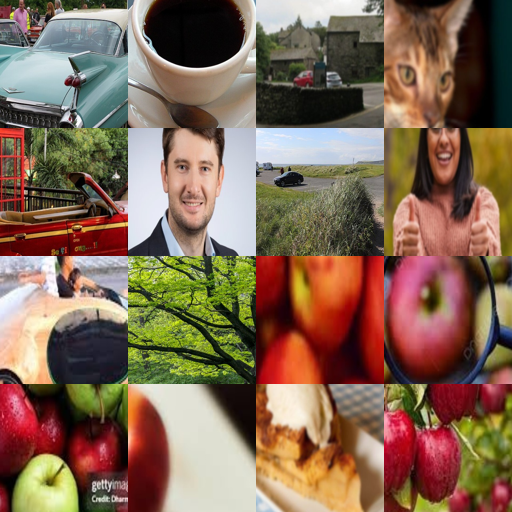

In [ ]:
# === Cell 4: Build a secret grid ===
SECRET_TEXT = "HELLO"   # change as needed
GRID_SIZE   = 4         # or None for auto-square
TILE_SIZE   = 128

secret_img, hex_str = make_secret_grid(SECRET_TEXT, grid_size=GRID_SIZE, tile_size=TILE_SIZE)
secret_path = os.path.join(OUTPUTS_DIR, f"secret_{SECRET_TEXT}.png")
secret_img.save(secret_path)
print("Text → HEX:", hex_str)
print("Saved secret grid at:", secret_path)
secret_img


In [ ]:
# === Cell 5: Style Transfer Helpers (no TV) ===
def image_loader(path, imsize=256, device=device):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])
    img = Image.open(path).convert("RGB")
    img = loader(img).unsqueeze(0)  # [1,3,H,W]
    print(f"Loaded {path}, shape:", img.shape)
    return img.to(device, torch.float)

def im_to_pil(tensor):
    t = tensor.clone().detach().cpu().squeeze(0)
    t = torch.clamp(t, 0, 1)
    return transforms.ToPILImage()(t)

def gram_matrix(x):
    b, ch, h, w = x.size()
    features = x.view(b, ch, h*w)
    G = torch.bmm(features, features.transpose(1,2))
    return G / (ch * h * w)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
        self.loss = 0
    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = gram_matrix(target).detach()
        self.loss = 0
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

def replace_relu_with_outplace(module):
    for name, layer in module.named_children():
        if isinstance(layer, nn.ReLU):
            setattr(module, name, nn.ReLU(inplace=False))
        else:
            replace_relu_with_outplace(layer)

cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
replace_relu_with_outplace(cnn)

def get_model_and_losses(cnn, style_img, content_img):
    content_layers = ['21']                  # relu4_2
    style_layers   = ['0','5','10','19','28']  # relu1_1 ... relu5_1

    model = nn.Sequential().to(device)
    style_losses, content_losses = [], []
    i = 0
    for layer in cnn.children():
        model.add_module(str(i), layer)
        if str(i) in style_layers:
            target = model(style_img).detach()
            sl = StyleLoss(target)
            model.add_module("style_loss_"+str(i), sl)
            style_losses.append(sl)
        if str(i) in content_layers:
            target = model(content_img).detach()
            cl = ContentLoss(target)
            model.add_module("content_loss_"+str(i), cl)
            content_losses.append(cl)
        i += 1
    return model, style_losses, content_losses

def generate_stego(secret_path, cover_path, out_path, imsize=256, alpha=0.1, beta=4e4, steps=200):
    content_img = image_loader(secret_path, imsize, device)  # secret/content
    style_img   = image_loader(cover_path,  imsize, device)  # cover/style

    # start from COVER clone → stego ≈ cover
    input_img = style_img.clone()

    model, style_losses, content_losses = get_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    run = [0]
    while run[0] <= steps:
        def closure():
            optimizer.zero_grad()
            input_img.data.clamp_(0,1)
            model(input_img)
            style_score   = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = alpha*content_score + beta*style_score
            loss.backward()
            run[0] += 1
            if run[0] % 20 == 0 or run[0] == steps:
                print(f"Step {run[0]} | Content {content_score.item():.4e} | Style {style_score.item():.4e}")
            return loss
        optimizer.step(closure)

    input_img.data.clamp_(0,1)
    out = im_to_pil(input_img)
    out.save(out_path)
    print("✅ Stego image saved:", out_path)
    return out


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 73.2MB/s]


Loaded /content/outputs/secret_HELLO.png, shape: torch.Size([1, 3, 256, 256])
Loaded /content/mountain.jpg, shape: torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Step 20 | Content 4.7845e+01 | Style 1.0768e-05
Step 40 | Content 3.6949e+01 | Style 1.2938e-05
Step 60 | Content 3.1991e+01 | Style 1.3988e-05
Step 80 | Content 2.9346e+01 | Style 1.4599e-05
Step 100 | Content 2.7650e+01 | Style 1.4748e-05
Step 120 | Content 2.6637e+01 | Style 1.4841e-05
Step 140 | Content 2.5948e+01 | Style 1.4867e-05
Step 160 | Content 2.5469e+01 | Style 1.4826e-05
Step 180 | Content 2.5080e+01 | Style 1.4865e-05
Step 200 | Content 2.4769e+01 | Style 1.4887e-05
Step 220 | Content 2.4509e+01 | Style 1.4911e-05
✅ Stego image saved: /content/outputs/stego_secret_HELLO.png


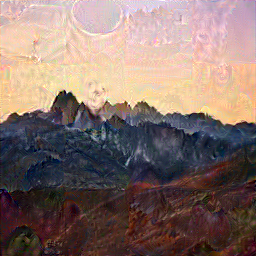

In [ ]:
# === Cell 6: Generate final stego ===
# Paths:
secret_path = secret_path  # from Cell 4
cover_path  = "/content/mountain.jpg"   # <-- change to your cover image
out_path    = os.path.join(OUTPUTS_DIR, f"stego_{os.path.basename(secret_path)}")

# Cover-dominant settings (stego ≈ cover). Increase steps to 300 if needed.
stego = generate_stego(secret_path, cover_path, out_path,
                       imsize=256, alpha=0.1, beta=4e4, steps=200)
stego


In [9]:
# === Use ANY image as secret (no hex grid) ===
from PIL import Image
import os

# Pick your files
secret_img_path = "/content/enormity.jpg"   # <-- upload your secret image
cover_img_path  = "/content/mountain.jpg"     # <-- your cover image
out_path        = "/content/outputs/stego_any_secret.png"

# (Optional) ensure they exist
assert os.path.exists(secret_img_path), f"Missing: {secret_img_path}"
assert os.path.exists(cover_img_path),  f"Missing: {cover_img_path}"

# Generate stego (secret = content, cover = style)
stego = generate_stego(
    secret_path=secret_img_path,
    cover_path=cover_img_path,
    out_path=out_path,
    imsize=256,           # both resized to 256x256
    alpha=0.1,            # secret weight (lower = less visible)
    beta=4e4,             # cover weight (higher = more cover-like)
    steps=80             # increase to 300–400 if needed
)
stego.show()
print("Saved:", out_path)


Loaded /content/enormity.jpg, shape: torch.Size([1, 3, 256, 256])
Loaded /content/mountain.jpg, shape: torch.Size([1, 3, 256, 256])
Step 20 | Content 1.9947e+01 | Style 6.1901e-06
Step 40 | Content 1.4649e+01 | Style 6.9394e-06
Step 60 | Content 1.1928e+01 | Style 7.1371e-06
Step 80 | Content 1.0491e+01 | Style 7.0999e-06
Step 100 | Content 9.5181e+00 | Style 7.1559e-06
✅ Stego image saved: /content/outputs/stego_any_secret.png
Saved: /content/outputs/stego_any_secret.png
